In [5]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [6]:
from PIL import Image
print(Image.__file__)

C:\Users\Kiran\anaconda3\lib\site-packages\PIL\Image.py


In [7]:
import Image
print(Image.__file__)

C:\Users\Kiran\anaconda3\lib\site-packages\PIL\Image.py


In [9]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [10]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 1

In [11]:
DIRECTORY = r"D:\KSU Classes\GRA\Kiran\Latest Dataset"
CATEGORIES = ["85-95","96-110", "111-125"]

In [12]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


In [26]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)



data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [31]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [32]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 0s 0us/step


In [33]:


# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)


In [34]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [35]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


C:\Users\Kiran\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training head...
Epoch 1/20
268/268 [==============================] - 22s 57ms/step - loss: 0.6960 - accuracy: 0.4291 - val_loss: 0.6060 - val_accuracy: 0.5000
Epoch 2/20
268/268 [==============================] - 14s 53ms/step - loss: 0.6524 - accuracy: 0.4403 - val_loss: 0.6101 - val_accuracy: 0.5147
Epoch 3/20
268/268 [==============================] - 14s 52ms/step - loss: 0.6212 - accuracy: 0.4963 - val_loss: 0.6225 - val_accuracy: 0.4853
Epoch 4/20
268/268 [==============================] - 14s 52ms/step - loss: 0.6277 - accuracy: 0.4552 - val_loss: 0.6114 - val_accuracy: 0.5294
Epoch 5/20
268/268 [==============================] - 14s 52ms/step - loss: 0.6095 - accuracy: 0.4888 - val_loss: 0.6044 - val_accuracy: 0.5147
Epoch 6/20
268/268 [==============================] - 14s 52ms/step - loss: 0.6067 - accuracy: 0.4888 - val_loss: 0.6227 - val_accuracy: 0.5441
Epoch 7/20
268/268 [==============================] - 14s 52ms/step - loss: 0.6042 - accuracy: 0.4925 - val_loss

In [37]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
68/68 [==============================] - 6s 39ms/step


In [38]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


In [39]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

     111-125       0.00      0.00      0.00        15
       85-95       0.52      0.97      0.67        33
      96-110       0.83      0.25      0.38        20

    accuracy                           0.54        68
   macro avg       0.45      0.41      0.35        68
weighted avg       0.50      0.54      0.44        68



C:\Users\Kiran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kiran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kiran\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# serialize the model to disk
print("[INFO] saving Glucose detector model...")
model.save("Glucose_detector.model", save_format="h5")

[INFO] saving Glucose detector model...


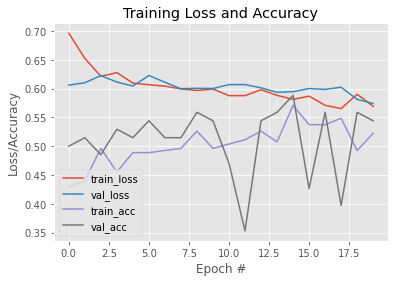

In [41]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

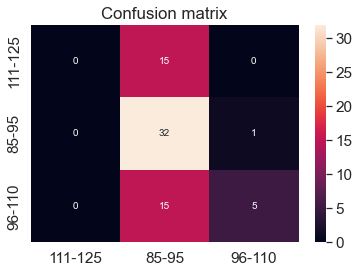

In [42]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt   

rounded_labels=np.argmax(testY, axis=1)
rounded_labels[1]

CM = confusion_matrix(rounded_labels, predIdxs)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=lb.classes_, 
           yticklabels=lb.classes_, ax = ax)
ax.set_title('Confusion matrix')
plt.show()